# 03-Lab_01-08-2025

## Decision Tree Classifier

### DataSet Used :- Cars Dataset

#### Setup Section

In [5]:
pip install pandas scikit-learn matplotlib seaborn scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

# Inline charts
%matplotlib inline

sns.set_theme(style="whitegrid", font_scale=1.1)

#### Usage Of CSV Dataset

In [7]:
#  Fetching & inspecting the data
df = pd.read_csv('Dataset/cars.csv')

# Clean up & create numeric columns
df['Price'] = df['Ex-Showroom_Price'] \
                .str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Displacement'] = df['Displacement'] \
                       .str.replace(' cc', '', regex=False).astype(float)

# Target: Emission_Norm
print("Unique Emission Norm classes:", df['Emission_Norm'].unique())
print("\nData Info:")
df.info()
print("\nFirst 5 rows:")
display(df.head())

Unique Emission Norm classes: ['BS IV' 'BS 6' nan 'BS III' 'BS VI']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Columns: 141 entries, Make to Price
dtypes: float64(8), object(133)
memory usage: 1.4+ MB

First 5 rows:


,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,...,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range,Price
0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624.0,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292667.0
1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624.0,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236447.0
2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624.0,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296661.0
3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624.0,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334768.0
4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624.0,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272223.0


#### Correlation of variables & Plot the Heat-map

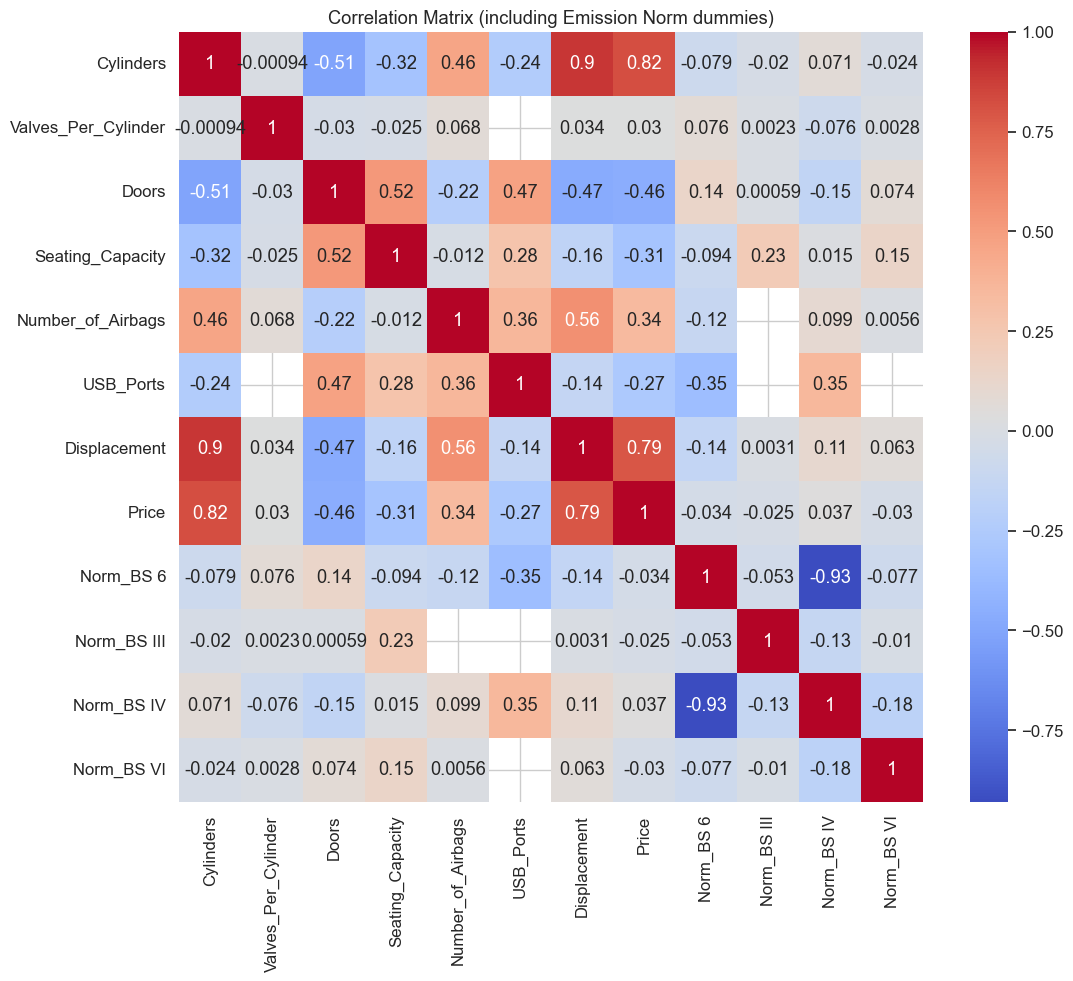

In [8]:
#  Correlation of variables & Plot the Heat-map

# Select numeric features + one-hot encode Emission_Norm for correlation
num_feats = ['Cylinders','Valves_Per_Cylinder','Doors','Seating_Capacity',
             'Number_of_Airbags','USB_Ports','Displacement','Price']
corr_df = df[num_feats].join(
    pd.get_dummies(df['Emission_Norm'], prefix='Norm')
).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (including Emission Norm dummies)")
plt.show()

#### Data Cleaning & Preprocessing

In [9]:
# Preprocessing with Feature Correlation and Feature Selection

# Compute absolute correlation of each feature with each Norm dummy, then average
norm_cols = [c for c in corr_df.columns if c.startswith('Norm_')]
feature_importance = {}

for feat in num_feats:
    feature_importance[feat] = np.mean(
        [abs(corr_df.at[feat, norm]) for norm in norm_cols]
    )

# Create a sorted DataFrame of features by their mean absolute correlation
feat_imp_df = pd.DataFrame.from_dict(
    feature_importance, orient='index', columns=['MeanAbsCorr']
).sort_values(by='MeanAbsCorr', ascending=False)

print("Features ranked by mean absolute correlation with Emission Norm classes:")
display(feat_imp_df)

# Select top 5 features for classification
selected_features = feat_imp_df.index[:5].tolist()
print("Selected features:", selected_features)

Features ranked by mean absolute correlation with Emission Norm classes:


,MeanAbsCorr
Seating_Capacity,0.120438
Doors,0.091717
Displacement,0.079201
Cylinders,0.048404
Valves_Per_Cylinder,0.039332
Price,0.031542
Number_of_Airbags,NaN
USB_Ports,NaN


Selected features: ['Seating_Capacity', 'Doors', 'Displacement', 'Cylinders', 'Valves_Per_Cylinder']


#### Prepare data & split into train/test

In [10]:
# Prepare data & split into train/test

# Inputs (X) and target (y)
X = df[selected_features]
y = df['Emission_Norm']

# Encode target classes to integers
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.25, random_state=0
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (957, 5) Test size: (319, 5)


#### Feature Scaling

In [11]:
# Feature scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

#### Classification using Decision Tree Classifier

In [12]:
# Classification using Decision Tree Classifier

# Instantiate with entropy criterion and max_depth=6 as in lab
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)
dt.fit(X_train_scaled, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### Predicting & evaluating the model

In [13]:
# Predicting & evaluating the model

y_pred = dt.predict(X_test_scaled)

# 8.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 8.2 Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of Decision Tree Classifier on Emission Norm dataset: {acc*100:.2f}%")


Confusion Matrix:
 [[ 33   0  59   1   1]
 [  0   1   1   0   0]
 [ 13   1 202   0   1]
 [  0   0   0   4   0]
 [  0   0   1   0   1]]

Accuracy of Decision Tree Classifier on Emission Norm dataset: 75.55%


#### Plotting the Confusion Matrix for clarity

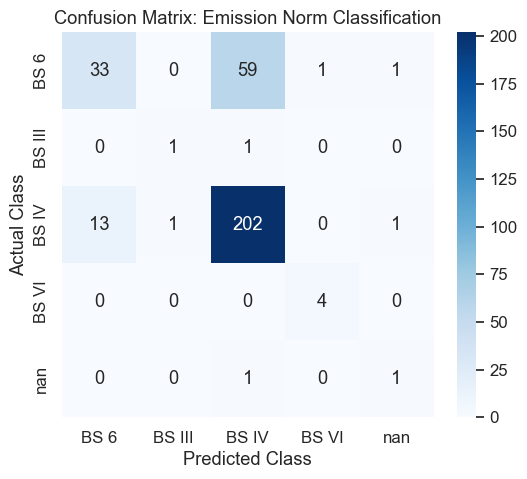

In [14]:
# Plotting the Confusion Matrix for clarity

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix: Emission Norm Classification')
plt.show()